<a href="https://colab.research.google.com/github/ElizabethB111/land-spatial-modeling/blob/main/1_forests_spatial_modeling_profiling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: @article{helber2017eurosat,
   title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
   author={Helber, et al.},
   journal={ArXiv preprint arXiv:1709.00029},
   year={2017}
}

https://huggingface.co/datasets/blanchon/EuroSAT_RGB

In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
pip install datasets


In [32]:
# --- Imports ---
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# ---Load Data----
EuroSAT_RGB = load_dataset("blanchon/EuroSAT_RGB")
EuroSAT_RGB

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})

In [34]:
# Basic Dataset Information
# Number of rows per split
for split in EuroSAT_RGB:
    print(f"{split}: {len(EuroSAT_RGB[split])} rows")

train: 16200 rows
test: 5400 rows
validation: 5400 rows


In [35]:
# Features (columns)
EuroSAT_RGB["train"].features

{'image': Image(mode=None, decode=True),
 'label': ClassLabel(names=['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']),
 'filename': Value('string')}

In [36]:
column_info = pd.DataFrame({
    "Column": ["image", "label", "filename"],
    "Type": ["Image (RGB, 64x64)", "Categorical (10 classes)", "String"],
    "Description": [
        "Satellite image patch",
        "Land use / land cover category",
        "Original image filename"
    ]
})

column_info


,Column,Type,Description
0,image,"Image (RGB, 64x64)",Satellite image patch
1,label,Categorical (10 classes),Land use / land cover category
2,filename,String,Original image filename


The dataset has three high-level columns. The image column expands into 12,288 numeric features (64×64×3 RGB pixels).

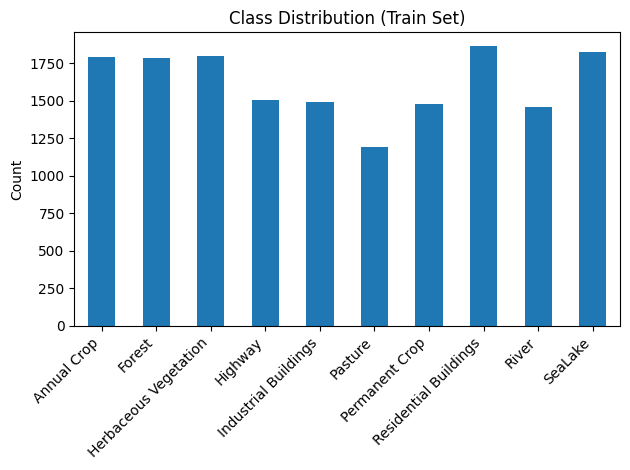

In [37]:
# Label Distribution (Class Balance)
labels = EuroSAT_RGB["train"].features["label"].names
label_counts = (
    pd.Series(EuroSAT_RGB["train"]["label"])
    .value_counts()
    .sort_index()
)
label_counts.index = labels
label_counts


label_counts.plot(kind="bar")
plt.title("Class Distribution (Train Set)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

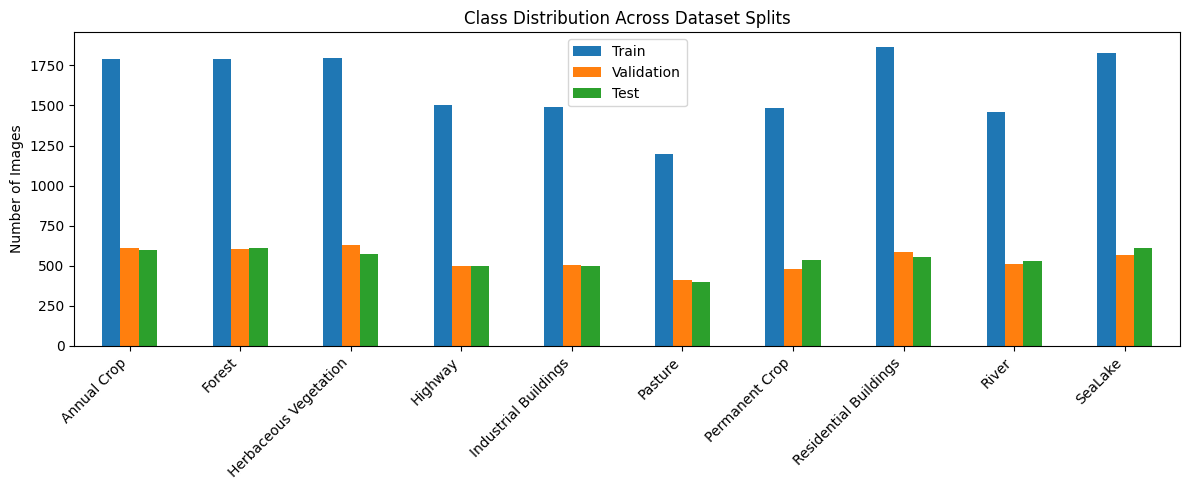

In [38]:
# Visualize plot distribution across data sets

def plot_split_distribution(dataset, split_name):
    counts = (
        pd.Series(dataset[split_name]["label"])
        .value_counts()
        .sort_index()
    )
    counts.index = labels
    return counts


dist_df = pd.DataFrame({
    "Train": plot_split_distribution(EuroSAT_RGB, "train"),
    "Validation": plot_split_distribution(EuroSAT_RGB, "validation"),
    "Test": plot_split_distribution(EuroSAT_RGB, "test")
})

dist_df.plot(kind="bar", figsize=(12, 5))
plt.title("Class Distribution Across Dataset Splits")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The classes are fairly balanced across land-cover categories, which will reduce the risk of class imbalance bias.

In [39]:
# Check image size and mode
sample = EuroSAT_RGB["train"][0]["image"]
print("Image size:", sample.size)
print("Image mode:", sample.mode)

Image size: (64, 64)
Image mode: RGB


Pixel Statistics


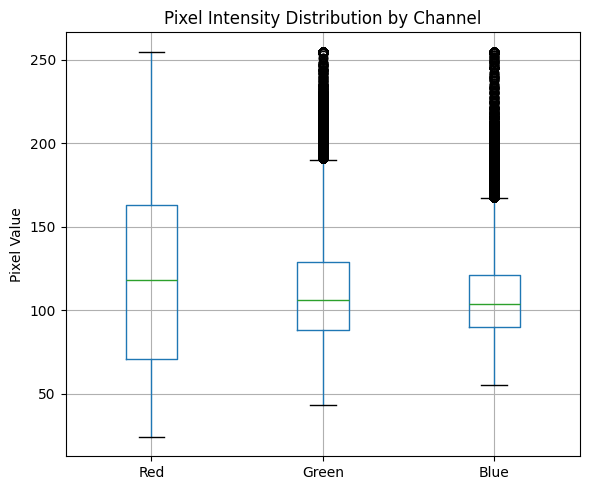

In [40]:
# Collect pixel data for a sample of images to create pixel_df
num_samples = 200  # Sample size, similar to other analysis cells
all_pixels = []

for i in range(num_samples):
    img = np.array(EuroSAT_RGB["train"][i]["image"])
    # Reshape the image to (pixels, channels) to easily extract channel values
    pixels_flat = img.reshape(-1, 3)  # assuming RGB (64x64x3 -> 4096x3)
    all_pixels.append(pixels_flat)

# Concatenate all pixel data into a single array
all_pixels_array = np.vstack(all_pixels)

# Create a DataFrame for the boxplot, mapping columns to channels
pixel_df = pd.DataFrame(all_pixels_array, columns=['Red', 'Green', 'Blue'])

# Now, the original plotting code can run
pixel_df.boxplot(figsize=(6, 5))
plt.title("Pixel Intensity Distribution by Channel")
plt.ylabel("Pixel Value")
plt.tight_layout()
plt.show()

Blue is skewed darker, probably vegetation or water.

Red has a longer bright tail, probably soil, rooftops, or roads.

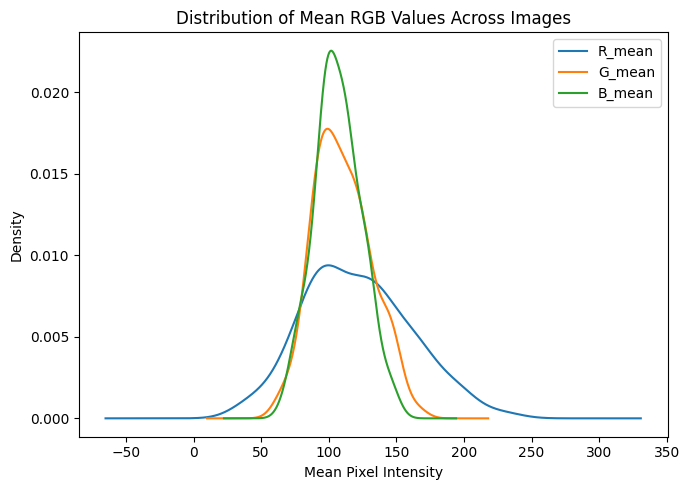

In [41]:
#Distribution of Mean RDB Values across Images

channel_means = []

for i in range(200):
    img = np.array(EuroSAT_RGB["train"][i]["image"])
    channel_means.append(img.mean(axis=(0, 1)))

channel_means_df = pd.DataFrame(channel_means, columns=["R_mean", "G_mean", "B_mean"])

channel_means_df.plot(kind="density", figsize=(7, 5))
plt.title("Distribution of Mean RGB Values Across Images")
plt.xlabel("Mean Pixel Intensity")
plt.tight_layout()
plt.show()


The full range of color means the data isn't broken or clipped, and that I should normalize later on.

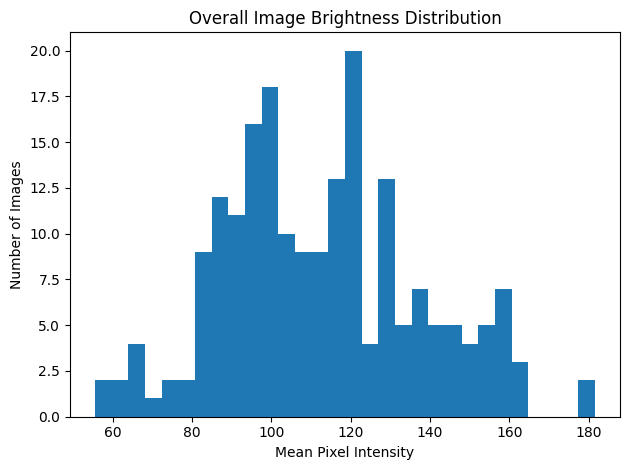

In [42]:
#Image Brightness Distribution

brightness = []

for i in range(200):
    img = np.array(EuroSAT_RGB["train"][i]["image"])
    brightness.append(img.mean())

plt.hist(brightness, bins=30)
plt.title("Overall Image Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [43]:

# Check for missing labels or images
labels_series = pd.Series(EuroSAT_RGB["train"]["label"])
filenames_series = pd.Series(EuroSAT_RGB["train"]["filename"])

print("Missing labels:", labels_series.isna().sum())
print("Missing filenames:", filenames_series.isna().sum())


Missing labels: 0
Missing filenames: 0


In [44]:
# Check for broken images
broken_images = 0
for i in range(100):
    try:
        _ = np.array(EuroSAT_RGB["train"][i]["image"])
    except Exception:
        broken_images += 1

print("Broken images (sample of 100):", broken_images)


Broken images (sample of 100): 0


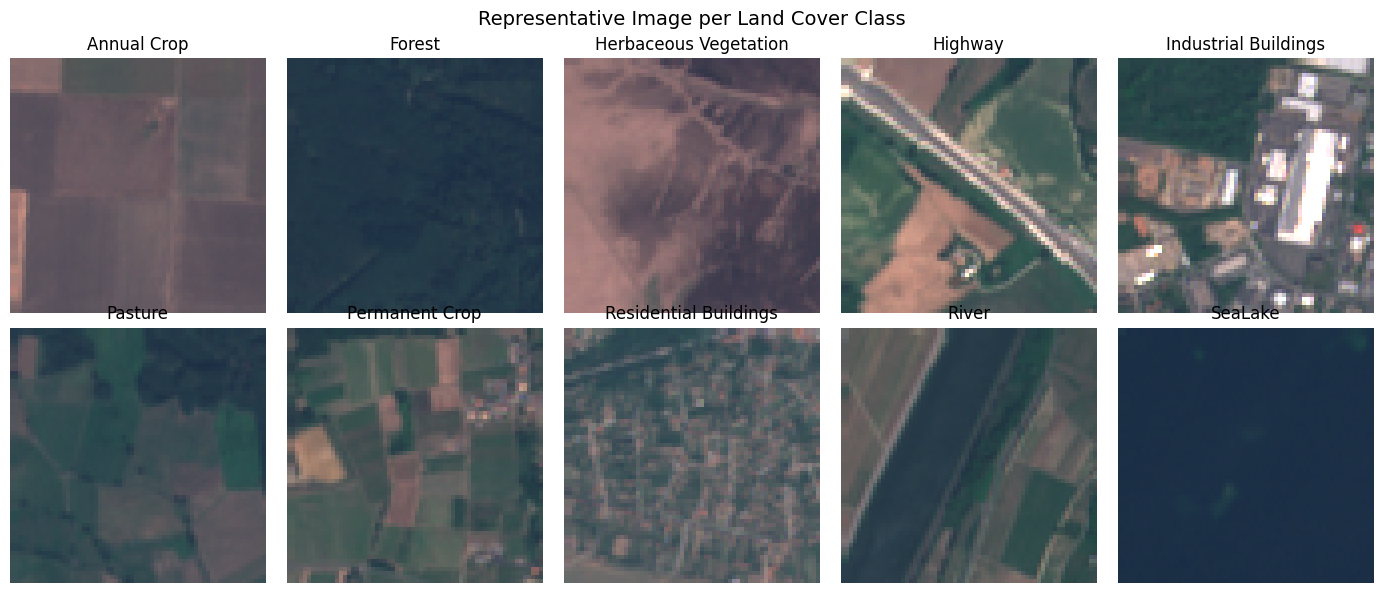

In [45]:
#Visualize representative images per land cover class
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

for class_idx, ax in enumerate(axes.flatten()):
    sample_idx = EuroSAT_RGB["train"]["label"].index(class_idx)
    sample = EuroSAT_RGB["train"][sample_idx]
    ax.imshow(sample["image"])
    ax.set_title(labels[class_idx])
    ax.axis("off")

plt.suptitle("Representative Image per Land Cover Class", fontsize=14)
plt.tight_layout()
plt.show()
